# Microsoft Stock Time Series Analysis

In [203]:
# Importing Packages

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [204]:
# Reading in the Data

df = pd.read_csv('Data/Microsoft_Stock.csv', index_col='Date', parse_dates=True)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438


In [205]:
df.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2021-03-25 16:00:00,235.30,236.94,231.57,232.34,34061853
2021-03-26 16:00:00,231.55,236.71,231.55,236.48,25479853
2021-03-29 16:00:00,236.59,236.80,231.88,235.24,25227455
2021-03-30 16:00:00,233.53,233.85,231.10,231.85,24792012
2021-03-31 16:00:00,232.91,239.10,232.39,235.77,43623471


In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1511 entries, 2015-04-01 16:00:00 to 2021-03-31 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1511 non-null   float64
 1   High    1511 non-null   float64
 2   Low     1511 non-null   float64
 3   Close   1511 non-null   float64
 4   Volume  1511 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 70.8 KB


In [207]:
df.describe()

,Open,High,Low,Close,Volume
count,1511.000000,1511.000000,1511.000000,1511.000000,1.511000e+03
mean,107.385976,108.437472,106.294533,107.422091,3.019863e+07
std,56.691333,57.382276,55.977155,56.702299,1.425266e+07
min,40.340000,40.740000,39.720000,40.290000,1.016120e+05
25%,57.860000,58.060000,57.420000,57.855000,2.136213e+07
50%,93.990000,95.100000,92.920000,93.860000,2.662962e+07
75%,139.440000,140.325000,137.825000,138.965000,3.431962e+07
max,245.030000,246.130000,242.920000,244.990000,1.352271e+08


### Possible Problems

- Data is collected daily, but not collected during weekends.
- Possible solution: Resampling weekly, use .interpolate()m or leave them be.

## Data Cleaning

## Data Visualization

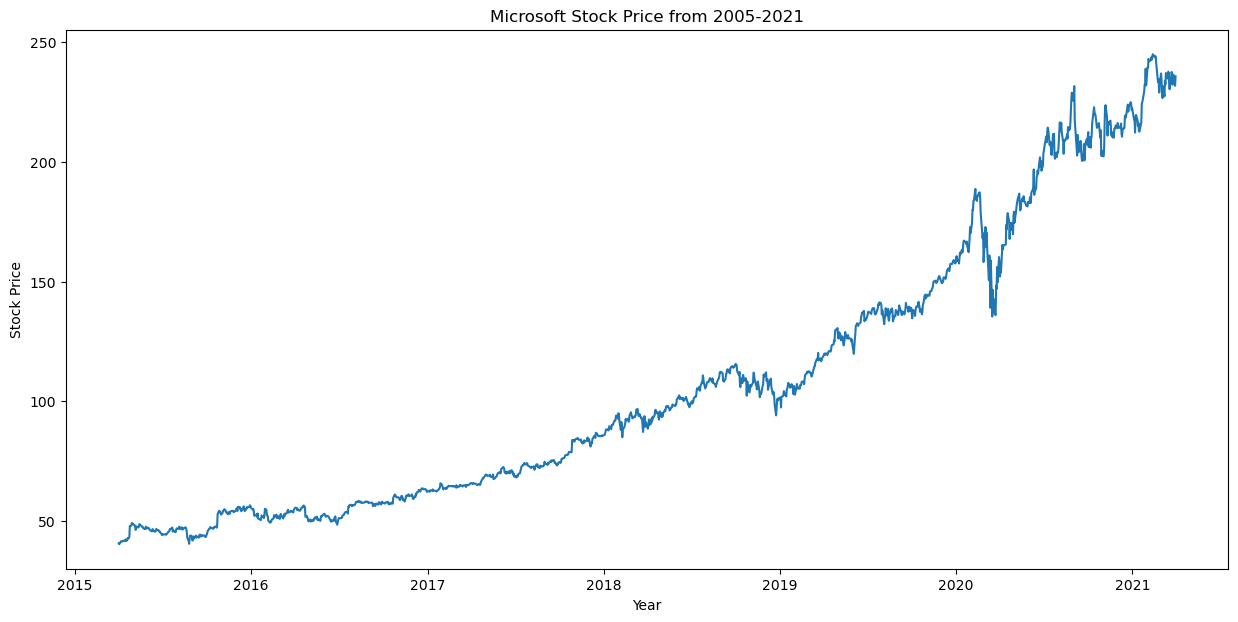

In [208]:

plt.figure(figsize=(15,7))

plt.plot(df['Close'])
plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.title('Microsoft Stock Price from 2005-2021')
plt.show();

### Takeaway

- The closing price of Microsoft stock has been steading increasing since 2015.
- We see a decrease between 2020-2021.

- It seems that there is an increasing trend, which could indicate non-stationarity.

## Testing for Stationarity

In [209]:
# Perform Dickey-Fuller Test

result = adfuller(df['Close'])

print('ADF Statistic: %f' % result[0])
print('P-Value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 1.737136
P-Value: 0.998216
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568


### Takeaway

Dickey-Fuller test is a statistical test used to determine the presence of a unit root in a time series data, which is indicative of non-stationarity.

- Test statistic = 1.737136


- P-value = 0.998216

Since P-Value is not less than .05, we fail to reject the null hypothesis. This implies that the time-series dataset is not stationary

## Removing Non-Stationarity

In [161]:
series_df = df['Close'].diff()

<Axes: xlabel='Date'>

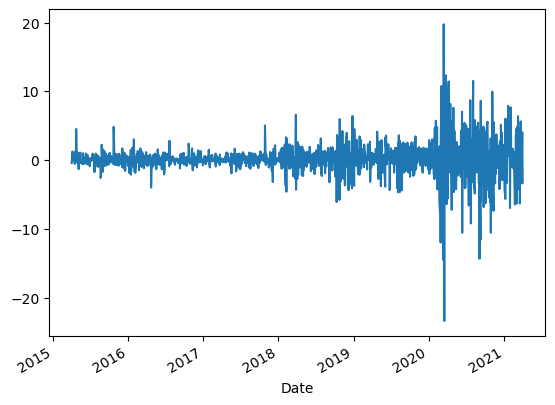

In [162]:
# Removing Trends

series_df.plot()

In [163]:
# Performing Dickey-Fuller Test to confirm

#adf1 = adfuller(series_df.dropna())

#print('ADF Statistic: %f' % adf1[0])
#print('P-Value: %f' % adf1[1])
#print('Critical Values:')
#for key, value in adf1[4].items():
#    print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.038331
P-Value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568


### Takeaway

- P-Value is now <0.05, which means that it is now stationary.

## Data Preprocessing

In [210]:
y_target = df['Close']
X_feat = df.iloc[:, 0:3]

In [211]:
# Feature Scaling

#sc = MinMaxScaler()
#X_ft = sc.fit_transform(X_feat.values)
#X_ft = pd.DataFrame(columns=X_feat.columns,
#                    data=X_ft,
#                    index=X_feat.index)

## Train Test Split

In [212]:
df_Close = df['Close']

cutoff = round(df_Close.shape[0]*0.8)
cutoff

1209

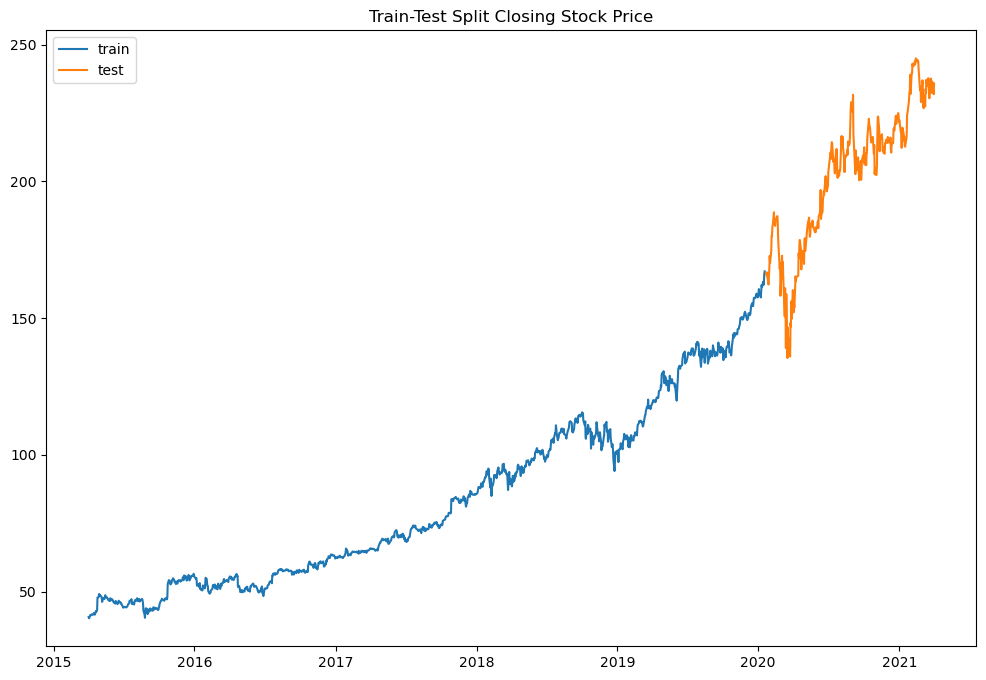

In [213]:
trainC = df_Close[:cutoff]

testC = df_Close[cutoff:]

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(trainC, label='train')
ax.plot(testC, label='test')
ax.set_title('Train-Test Split Closing Stock Price')
plt.legend();

## Modeling

### Naive

In [214]:
print(trainC.shape)
print(testC.shape)

(1209,)
(302,)


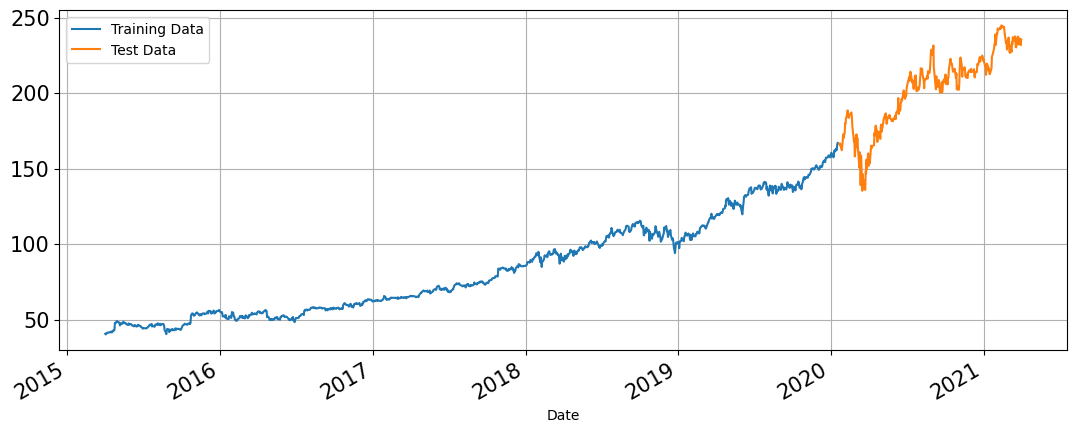

In [215]:
trainC.plot(figsize=(13, 5), fontsize=15)
testC.plot(figsize=(13, 5), fontsize=15)
plt.grid()
plt.legend(['Training Data', 'Test Data'])
plt.show();

In [216]:
naiveC = trainC.shift(1)
naiveC

Date
2015-04-01 16:00:00       NaN
2015-04-02 16:00:00     40.72
2015-04-06 16:00:00     40.29
2015-04-07 16:00:00     41.55
2015-04-08 16:00:00     41.53
                        ...  
2020-01-13 16:00:00    161.34
2020-01-14 16:00:00    163.28
2020-01-15 16:00:00    162.13
2020-01-16 16:00:00    163.18
2020-01-17 16:00:00    166.17
Name: Close, Length: 1209, dtype: float64

In [217]:
# RMSE value for naive model

np.sqrt(mean_squared_error(trainC[1:], naiveC.dropna()))

1.244367575217088

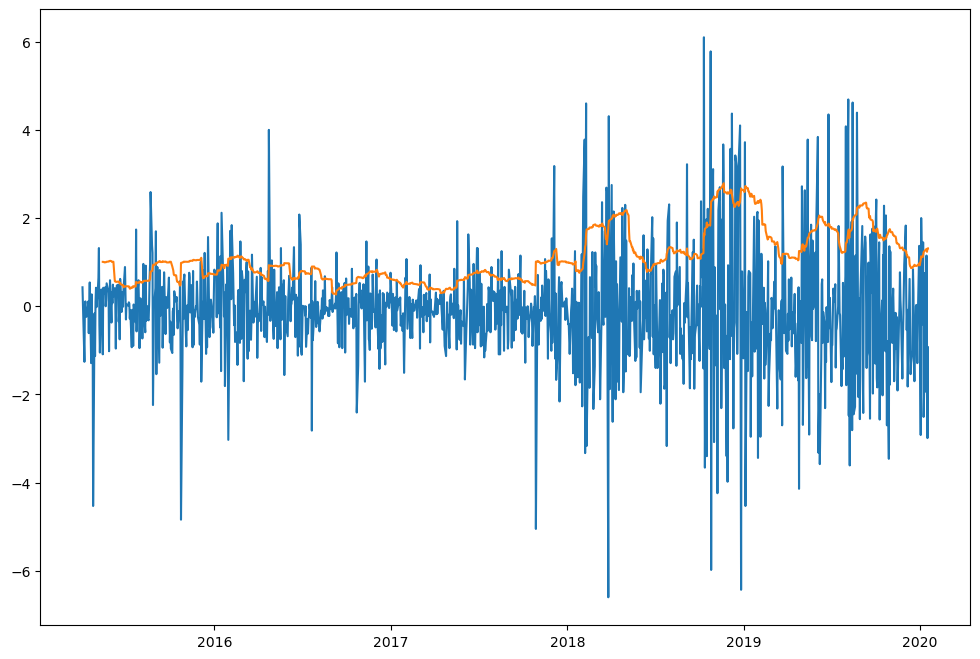

In [218]:
fig, ax = plt.subplots(figsize=(12, 8))

residuals = naiveC[1:] - trainC[1:]
ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(30).std());

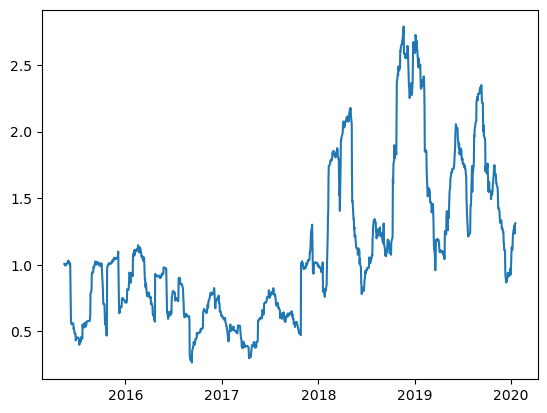

In [219]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals.rolling(30).std());

In [220]:
p_val_close = adfuller(trainC.diff()[1:])[1]
print(f"The P-Value associated with the Dickey-Fuller statistical test is {p_val_close},")
if p_val_close < 0.05:
    print(" so we can safely assume that the differenced data is stationary.")
else:
    print(" so we cannot reject the null hypothesis that the differenced data is not stationary")

The P-Value associated with the Dickey-Fuller statistical test is 5.416204808466411e-27,
 so we can safely assume tha the differenced data is stationary.


## ARIMA

In [222]:
ar_1 = ARIMA(trainC, order=(1, 1, 0)).fit()

ar_1.predict(typ='levels')

/Users/dre/anaconda3/envs/learn-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Date
2015-04-01 16:00:00      0.000000
2015-04-02 16:00:00     40.719993
2015-04-06 16:00:00     40.336120
2015-04-07 16:00:00     41.414859
2015-04-08 16:00:00     41.532145
                          ...    
2020-01-13 16:00:00    161.420441
2020-01-14 16:00:00    163.071925
2020-01-15 16:00:00    162.253343
2020-01-16 16:00:00    163.067382
2020-01-17 16:00:00    165.849307
Name: predicted_mean, Length: 1209, dtype: float64

In [223]:
ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1209
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1971.189
Date:                Mon, 18 Dec 2023   AIC                           3946.379
Time:                        09:43:22   BIC                           3956.572
Sample:                             0   HQIC                          3950.217
                               - 1209                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1073      0.019     -5.686      0.000      -0.144      -0.070
sigma2         1.5306      0.036     42.227      0.000       1.460       1.602
===================================================================================
Ljung-Box (L1) (Q):                   0.48   Jarque-Bera (JB):               888.52
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               4.49   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [225]:
ar_1.aic

3946.3786363381237

### Random Walk Model

In [226]:
random_walk_model = ARIMA(trainC, order=(0, 1, 0)).fit()
random_walk_model.summary()

/Users/dre/anaconda3/envs/learn-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1209
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1978.180
Date:                Mon, 18 Dec 2023   AIC                           3958.359
Time:                        10:15:05   BIC                           3963.456
Sample:                             0   HQIC                          3960.279
                               - 1209                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.5484      0.035     43.640      0.000       1.479       1.618
===================================================================================
Ljung-Box (L1) (Q):                  16.06   Jarque-Bera (JB):               968.63
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.60   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [227]:
random_walk_model.aic

3958.3593650647117

In [228]:
y_hat_ar1 = ar_1.predict(typ='levels')
np.sqrt(mean_squared_error(trainC, y_hat_ar1))

1.7031833039024702

In [229]:
y_hat_rw = random_walk_model.predict(typ='levels')
np.sqrt(mean_squared_error(trainC, y_hat_rw))

1.708405435344213

## Model Limitation

- Dataset does not include weekends.